In [8]:
import csv
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

Summary of procedure used for Q1 and Q2

Our motive is to calculate a score corresponding to each player and then group the players 
having similar scores together.
• The similarity of scores is decided by a threshold, which we have decided upon analysing the plot of number of clusters and various threshold values from 0.1 to 2. (We chose it 0.25 after analysing data)
• For grouping players together, we have used clustering algorithms (DBSCAN clustering)

Reading Data

1. We represent a TRUST by a '1', and a CHEAT by a '0'.
2. Each round of game between two players is represented by a list of two bit binary 
strings, wherein the list of games between player 1 and player 2, "00" represents 
(CHEAT, CHEAT), "01" represents (TRUST,TRUST), "10" represents 
(TRUST,CHEAT), "11" represents (TRUST,TRUST) for player1 and player 2 
respectively.

In [9]:
def read_csv_file(filename):
    data = []
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)
        for row in csv_reader:
            data.append(row)
    return data

filename = 'input_game.csv'
csv_data = read_csv_file(filename)

def distance_metric(a,b):
    return(abs(a-b))

my_dict=dict()

for row in csv_data:

    if row[1] not in my_dict.keys():
        temp = dict()
        my_dict[row[1]] = temp

    temp = my_dict[row[1]]

    if row[2] not in temp.keys():
        list = []
        temp[row[2]]=list

    s=""

    if row[3]=="TRUST":
        s+="1"
    else:
        s+="0"

    if row[4]=="CHEAT":
        s+="0"
    else:
        s+="1"

    temp[row[2]].append(s)

    if row[2] not in my_dict.keys():
        temp1 = dict()
        my_dict[row[2]] = temp1

    temp1 = my_dict[row[2]]

    if row[1] not in temp1.keys():
        list1 = []
        temp1[row[1]]=list1

    s1=""

    if row[4]=="TRUST":
        s1+="1"
    else:
        s1+="0"

    if row[3]=="CHEAT":
        s1+="0"
    else:
        s1+="1"

    temp1[row[1]].append(s1)

Calculating Scores

1. By doing a bit of analysis, we obtained that the minimum number of turns per game is 
40, while maximum is 80 and average is 60. I assumed that on an average first ten 
percent games (first 6 games) are independent of opponents' actions.
2. We define a function f_i for each Player i, which takes four parameters (x1: #'00's, 
x2:#'01's, x3:#'10's, x4:#'11's) as input. We iterate from the seventh turn of each game 
and increment f_i(x1,x2,x3,x4) by 1 if Player i says '1' and decrement it by 1 if 
Player_i says '0'
Once we have obtained f_i values for each Player i, we obtain the score for each player 
through the following procedure:
1. Iterate over all possible keys (x1,x2,x3,x4) for which we have stored values.
2. Let s=x1+x2+x3+x4
3. The score is the sum of 
f_i(x1,x2,x3,x4)[(1+x1)/(80+s)][(1+x2)/(80+s)][(1+x3)/(80+s)][(1+x4)/(80+s)] 
over all possible keys defined in point 1.
4. The number 80 is chosen because maximum possible value of x_i is 80, which is the 
maximum number of turns in the dataset.

In [10]:
score_dct = dict()

for key in my_dict:

    p_dict = dict()
    score_dct[key] = p_dict

    for key2 in my_dict[key]:

        lst = my_dict[key][key2]
        sz = len(lst)

        c0=0
        c1=0
        c2=0
        c3=0

        for j in range(sz):

            if (j>5):
                t1 = (c0,c1,c2,c3)
                if t1 not in p_dict:
                    val = lst[j]
                    if val=="11" or val=="10":
                        p_dict[t1]=1
                    else:
                        p_dict[t1]=-1
                else:
                    val = lst[j]
                    if val=="11" or val=="10":
                        p_dict[t1]+=1
                    else:
                        p_dict[t1]-=1 

            if lst[j]=="00":
                c0+=1
            elif lst[j]=="01":
                c1+=1
            elif lst[j]=="10":
                c2+=1
            else:
                c3+=1

score = dict()

for key in score_dct:

    tect = score_dct[key]
    value=0

    for key2 in tect:

        x1=key2[0]
        x2=key2[1]
        x3=key2[2]
        x4=key2[3]
        t = x1+x2+x3+x4
        value+=((tect[key2])*((1+x1)/(80+t))*((1+x2)/(80+t))*((1+x3)/(80+t))*((1+x4)/(80+t)))
    
    value*=1000
    new_val = round(value,4)
    new_key = int(key)
    score[new_key] = new_val

Plot of number of clusters vs thresholds

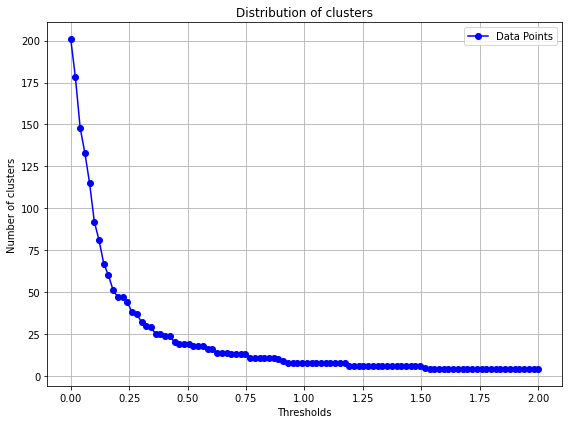

In [11]:
sorted_dict = {key: score[key] for key in sorted(score)}
sorted_dict_val = dict(sorted(score.items(), key=lambda item: item[1]))

val_lst = []

for key in sorted_dict_val:
    # print(key,sorted_dict_val[key])
    val_lst.append(sorted_dict_val[key])

start = 0.00001
stop = 2
num_points = 100
x = np.linspace(start, stop, num_points)
y = []

X = np.array(val_lst)
X1 = X.reshape(-1, 1)

for i in range(len(x)):
    eps = x[i]
    min_samples = 1
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X1)
    labels = dbscan.labels_
    y.append(labels[-1]+1)

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Data Points')
plt.title('Distribution of clusters')
plt.xlabel('Thresholds')
plt.ylabel('Number of clusters')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Seeing the elbow at 0.75, we decided to set the threshold to be 0.75. The value of number of clusters corresponding to 0.75 threshold is 13.

In [12]:
X = np.array(val_lst)
X1 = X.reshape(-1, 1)

for i in range(len(x)):
    eps = 0.75
    min_samples = 1
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X1)
    labels = dbscan.labels_
print("Number of clusters is:",labels[-1]+1)

Number of clusters is: 13


2-D array of player numbers having the same strategy

In [13]:
sorted_dict = {key: score[key] for key in sorted(score)}

val_lst = []

for key in sorted_dict:
    val_lst.append(sorted_dict[key])

X = np.array(val_lst)
X1 = X.reshape(-1, 1)

eps = 0.75
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X1)
labels = dbscan.labels_

final_dict = dict()

for i in range(len(labels)):

    if labels[i] not in final_dict:
        final_dict[labels[i]] = []
    
    final_dict[labels[i]].append(i+1)

print('[',end='')
for key in final_dict:
    print(final_dict[key],end=', ')
print(']')

[[1, 4, 5, 7, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 39, 40, 41, 42, 44, 46, 47, 48, 49, 51, 52, 54, 56, 58, 59, 60, 62, 63, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 87, 88, 90, 91, 92, 93, 94, 95, 98, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 132, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 192, 193, 194, 195, 198, 201], [2, 3, 6, 12, 43, 45, 69, 74, 80, 86, 89, 99, 126, 154, 161, 176, 186, 199], [8, 31, 127, 133, 191, 196], [14, 22, 37, 50, 53, 55, 57, 64, 85, 96, 97, 141, 189, 197], [23, 33], [36, 65, 148, 173, 200], [38, 105], [61], [101], [131], [139], [167], [190], ]
